# Used vehicles price prediction - A Machine Learning Project
### by Alexander Justin King Sing Ortiz
*first full ML project*

# ABSTRACT

This project was a born from a curiosity question of mine as I prepared for my MBA in the U.S. As many know, cars are the most common method of transportation in the U.S as trains, buses, as public transportation varies heavily by state and city, and, for most purposes, is not the preferred form of transport for many.

Considering that, I asked myself: "How much would it cost to buy a car in the U.S?" I immediately discarded new vehicles because they're substantially more expensive, depreciate rapidly and simply didn't adjust to my budget. The only option was an **used vehicles**. 

The question then changed to: "How much would it cost to buy a used car in the U.S?" It's sometimes difficult to find information that one considers both reliable and scalable and that has relevance over time, specially when P2P (Peer-to-Peer) markets are so heterogenous. Now, answering this question for myself would be relatively trivial: I just need to look for a car model I like and search for it. Simple, right? But I wanted to do more.

What if I wanted to check multiple vehicles? With multiple manufacture (MFG) dates? or vehicles with within a certain odometer range? These questions and more led me to think beyond a simple for this question. In light of this, and building on my curiosity about ML / DL, I decided to build a model to **estimate the value / price of a used vehicle in the U.S**.

Now, due to my current limited expertise in certain aspects of ML, I decided to limit the scope of the project.

**SCOPE**: 
* For time reasons I will **exclude** any kind of **image analysis**. Vehicle images (could be extracted from each post) will be ignored.
* In-depth NLP tasks are not in scope of this analysis, but some simple tasks may be used for feature extraction.
* Unique data points such as VIN, which are used in history analysis, will also be excluded.
* These exercise will attempt to create a single model to predict ALL used vehicles regardless of manufacturer or model. Under some circumstances (Tesla's for example) vehicles exhibit substantially different behaviours on price based on their brand and a specific Manufacturer-Regression-Model could be a much better approach. However, for simplicity's sake, I'll do a "one for all" model.

**A POSTERIORI ADJUSTMENT**:
As part of the data science discovery process, some adjustments were made to the premises of this analysis. These were:
* Since this analysis is focused in finding a model capable of predicting vehicle prices, and these vehicles need to be "common" (that is, used vehicles normally bought/sold) I need to have sufficient information to do be able to generate accurate predictions. As such, I will remove from datasets:
    * Manufacturers with less than 100 samples
    * Models with less than than 30 samples
    
In general, this exercise attempts to create a prediction model with minimal inputs and without complex encodings & transformations and without having to perform internet queries with some of the data.

Basically: **if the input cannot be directly inferred or understood with the provided data, it will be discarded**.

This analysis was carried out in May-June 2021

# Goals

In summary, this project has two main goals:

* First, and most important goal is: To create a regression model capable for predicting a used vehicle price.
* Second, and depending on the the results of the models, I  will attempt to obtain information what are the most important attributes (model weights).

The models used in this analysis were:
* Scikit-Learn Models:
    * Lasso Regression
    * Standard Linear Regression
    * Random Forest Regressor
    * Gradient Boosted Regressor
* Tensorflow-Keras:
    * Feed-forward Neural Network with 3 hidden layers

# Table of Contents
1. [Initialization](#Initialization)
    1. [Imports](#Imports)
    1. [Functions](#Functions)
1. [Data_exploration](#Data_exploration)
    1. [Handling_missing_data](#Handling_missing_data)
    2. [Exploratory_data_analysis](#Exploratory_data_analysis)
1. [Model_training](#Model_training)
    1. [Linear_models](#Linear_models)
    2. [Ensemble_regressors](#Ensemble_regressors)
    3. [Keras_model](#Keras_model)
1. [Model_evaluation](#Model_evaluation)

# Initialization

## Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# scikit-learn imports
## scikit tools
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

## joblib
from joblib import dump, load

## scikit models
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# setting style
plt.style.use("seaborn-colorblind")

The first thing I'll do after loading the data will be to analyze and discover columns that only have 1 value OR where each value is unique. Excluding geographical coordinates, features such as "ID" or otherwise unique identifiers do not assist for analysis.

In [2]:
# reading file and info
df = pd.read_csv("data/vehicles.csv")
df.nunique()

id              426880
url             426880
region             404
region_url         413
price            15655
year               114
manufacturer        42
model            29667
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118264
drive                3
size                 4
type                13
paint_color         12
image_url       241899
description     360911
county               0
state               51
lat              53181
long             53772
posting_date    381536
dtype: int64

We can observe that **ID** and **URL** are unique for each vehicle posting, so we can go ahead and discard them since they do not provide any useful insights.

Additionally, image analysis is not in the scope of this review, so I will also ignore **image_url**.

Finally, as mentioned in scope, I will delete VIN, since for the scope for of this project I will not be querying the car's history.

In [3]:
# deleting useless columns.
df = df.drop(columns = ["id", "url", "image_url", "VIN"])

Next, I'll analyze and discover missing data points and find out what to do with these columns!

## Functions

In [4]:
# Defining function to encode a dataframe.

def gen_array(dataframe : pd.DataFrame, cat_enc = None, num_enc = None) -> np.array:
    '''
    Generate a fit-ready array based on a dataframe.
    
    This function takes a pandas dataframe, separates it into "object" and "not object" slices.
    The slices are fit to their respect encoders, and finally both slices are concatenated.
    
    If encoders are not provided, they are instantiated inside the function, otherwise, use the provided encoders.
    
    Parameters
    ----------
    dataframe : Pandas Dataframe object
        Data structure to slice and encode.
    cat_enc : Scikit-learn categorical encoder (OneHot, Ordinal, or other.)
        Encoder for categorical data.
    num_enc : Scikit-learn numerical encoder (StandardScaler, MinMaxScaler, or other.)
        Encoder for numerical data.
    Returns
    -------
    a numpy array with the encoded attributes
    generated encoders
    
    '''
    if cat_enc is None and num_enc is None:
        
        # creating encoders for the data
        cat_encoder = OneHotEncoder(sparse = False, handle_unknown = "ignore") # setting Sparse to false because i'll need to concatenate the numerical variables later
        num_encoder = StandardScaler()
        
        cat_encoder.fit(dataframe.select_dtypes(include = "object"))
        num_encoder.fit(dataframe.select_dtypes(exclude = "object"))
        
    else:
        cat_encoder = cat_enc
        num_encoder = num_enc

    cat_slice = cat_encoder.transform(dataframe.select_dtypes(include = "object"))
    num_slice = num_encoder.transform(dataframe.select_dtypes(exclude = "object"))
    
    array = np.concatenate([cat_slice, num_slice], axis=1)
    
    return array, cat_encoder, num_encoder

def inverse_trans(array : np.array, cat_enc, num_enc):
    '''
    Inverse an encoded array or arrays into it's parent un-encoded parent object or a Pandas Dataframe (more than one sample).
    
    This function takes an array as an input and performs inverse transforms to return the array to its parent components.
    The design of this function is limited to the transformations made in the function gen_array, thus this function is EXTREMELY LIMITED IN SCOPE.
    
    Parameters
    ----------
    array : numpy array object
        Data structure to slice and inverse_encode.
    cat_enc : Scikit-learn categorical encoder (OneHot, Ordinal, or other.)
        Encoder for categorical data.
    num_enc : Scikit-learn numerical encoder (StandardScaler, MinMaxScaler, or other.)
        Encoder for numerical data.   
    Returns
    -------
    a numpy array with the inversed_encoded attributes
    '''
    cat_features = array[:,:-2]
    num_features = array[:,-2:]
    
    if cat_features.shape[0] == 1:
        
        cat_features = cat_enc.inverse_transform(cat_features.reshape(1, -1))
        num_features = num_enc.inverse_transform(num_features.reshape(1, -1))
        
        fin_array = np.concatenate([cat_features, num_features], axis=1)
        
        return fin_array
        
    else:
        
        cat_features = cat_enc.inverse_transform(cat_features)
        num_features = num_enc.inverse_transform(num_features)
        
        fin_array = np.concatenate([cat_features, num_features], axis=1)
        
        return fin_array

# Data_exploration

## Handling_missing_data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   region_url    426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  drive         296313 non-null  object 
 13  size          120519 non-null  object 
 14  type          334022 non-null  object 
 15  paint_color   296677 non-null  object 
 16  description   426810 non-null  object 
 17  county        0 non-null       float64
 18  stat

Df.info() provides a good insight into the missing information, but let's try a different way to see how much missing data do we really have

In [6]:
# calculating all missing data points and normalizing to df size
(df.isna().sum() * 100 / df.shape[0]).to_frame().T # setting the count as an horizontally-oriented frame for better visualization

,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,drive,size,type,paint_color,description,county,state,lat,long,posting_date
0,0.0,0.0,0.0,0.282281,4.133714,1.236179,40.785232,41.62247,0.705819,1.030735,...,30.586347,71.767476,21.752717,30.501078,0.016398,100.0,0.0,1.534155,1.534155,0.01593


As we can see, columns such as:
* County -> 100% missing data
* size -> 71.76% missing data

have large amounts of missing data that we can outright consider impossible to fix, so we will just delete them.

In [7]:
# I'll delete the columns with too much missing data to be recoverable
df = df.drop(columns = ["county", "size"])

In [8]:
# let's start exploring some of the remaining information to understand what kind of information do we have at hand
## To begin with, let's start exploring REGION & REGION_URL
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   region_url    426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  drive         296313 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  description   426810 non-null  object 
 16  state         426880 non-null  object 
 17  lat           420331 non-null  float64
 18  long

In [9]:
# Top 10 records in region
df["region"].unique()[:10]

array(['prescott', 'fayetteville', 'florida keys',
       'worcester / central MA', 'greensboro', 'hudson valley',
       'medford-ashland', 'erie', 'el paso', 'bellingham'], dtype=object)

In [10]:
# top 10 records in region URL
df["region_url"].unique()[:10]

array(['https://prescott.craigslist.org', 'https://fayar.craigslist.org',
       'https://keys.craigslist.org', 'https://worcester.craigslist.org',
       'https://greensboro.craigslist.org',
       'https://hudsonvalley.craigslist.org',
       'https://medford.craigslist.org', 'https://erie.craigslist.org',
       'https://elpaso.craigslist.org',
       'https://bellingham.craigslist.org'], dtype=object)

In general, region and region_url seems to be related to the seller's location and both hold pretty much the same information.
So, for the time being, I will delete only one of them.

Additionally, since region already holds geographical information, we will discard lat and long.

In [11]:
df = df.drop(columns=["region_url", "lat", "long"])

Now, before we continue exploring the rest of columns with missing data or with possibly relevant features, let's verify if the description column holds any easily extractable information.

Remember we won't any in-depth NLP tasks for this project

In [12]:
df["description"].unique()[:2]

array([nan,
       "Carvana is the safer way to buy a car During these uncertain times, Carvana is dedicated to ensuring safety for all of our customers. In addition to our 100% online shopping and selling experience that allows all customers to buy and trade their cars without ever leaving the safety of their house, we’re providing touchless delivery that make all aspects of our process even safer. Now, you can get the car you want, and trade in your old one, while avoiding person-to-person contact with our friendly advocates. There are some things that can’t be put off. And if buying a car is one of them, know that we’re doing everything we can to keep you keep moving while continuing to put your health safety, and happiness first. Vehicle Stock# 2000909557📱 Want to instantly check this car’s availability? Call us at  334-758-9176Just text that stock number to 855-976-4304 or head to http://www.carvanaauto.com/7171237-74502 and plug it into the search bar!Get PRE-QUALIFIED for your a

Unfortunately it seems the description field holds a lot of information, but at this point i'm not considering using BERT for Named Entity Recognizition, Sentiment Analysis, or any other kind of relevant NLP task.

As such, I will delete description.

In [13]:
df = df.drop(columns = "description")

Now, **price** is our target so we will not perform any analysis in it.

Let's explore some more features!

In [14]:
# Analyzing condition
df["condition"].value_counts(dropna = False)

NaN          174104
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

In [15]:
# It seems condition is a simply a string describing the state of the vehicle, possibly from a dropdown menu. 
# In this case, instead of getting rid of the non-provided data we can fill with a placeholder string
df["condition"] = df["condition"].fillna(value = "Not relevant")
df["condition"].value_counts(dropna = False)

Not relevant    174104
good            121456
excellent       101467
like new         21178
fair              6769
new               1305
salvage            601
Name: condition, dtype: int64

In [16]:
df["cylinders"].value_counts(dropna = False)

NaN             177678
6 cylinders      94169
4 cylinders      77642
8 cylinders      72062
5 cylinders       1712
10 cylinders      1455
other             1298
3 cylinders        655
12 cylinders       209
Name: cylinders, dtype: int64

For simplicity's sake, I'll provide cylinders the same treatment as "condition".

In [17]:
df["cylinders"] = df["cylinders"].fillna(value = "Not relevant")
df["cylinders"].value_counts(dropna = False)

Not relevant    177678
6 cylinders      94169
4 cylinders      77642
8 cylinders      72062
5 cylinders       1712
10 cylinders      1455
other             1298
3 cylinders        655
12 cylinders       209
Name: cylinders, dtype: int64

In [18]:
df["drive"].value_counts(dropna = False)

4wd    131904
NaN    130567
fwd    105517
rwd     58892
Name: drive, dtype: int64

In [19]:
df["type"].value_counts(dropna = False)

NaN            92858
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: type, dtype: int64

In [20]:
df["paint_color"].value_counts(dropna = False)

NaN       130203
white      79285
black      62861
silver     42970
blue       31223
red        30473
grey       24416
green       7343
custom      6700
brown       6593
yellow      2142
orange      1984
purple       687
Name: paint_color, dtype: int64

In [21]:
df["fuel"].value_counts(dropna = False)

gas         356209
other        30728
diesel       30062
hybrid        5170
NaN           3013
electric      1698
Name: fuel, dtype: int64

In [22]:
df["title_status"].value_counts(dropna = False)

clean         405117
NaN             8242
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: title_status, dtype: int64

In [23]:
df["transmission"].value_counts(dropna = False)

automatic    336524
other         62682
manual        25118
NaN            2556
Name: transmission, dtype: int64

Drive, type, fuel, paint_color and the like have similarly high amounts of missing data, however we won't want to discard them as they might hold relevance for many sellers, so we will give them the same treatment as both condition and cylinders.

In [24]:
df["drive"] = df["drive"].fillna(value = "Not relevant")
df["type"] = df["type"].fillna(value = "Not relevant")
df["paint_color"] = df["paint_color"].fillna(value = "Not relevant")
df["fuel"] = df["fuel"].fillna(value = "Not relevant")
df["title_status"] = df["title_status"].fillna(value = "Not relevant")
df["transmission"] = df["transmission"].fillna(value = "Not relevant")

In [25]:
# Let's recalculate the missing to see how much we have done
(df.isna().sum() * 100 / df.shape[0]).to_frame().T

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,0.0,0.0,0.282281,4.133714,1.236179,0.0,0.0,0.0,1.030735,0.0,0.0,0.0,0.0,0.0,0.0,0.01593


We have gotten rid of remarkable amount of missing data, but we still have some missing data. At this point I evaluated my options:

The largest amount of remaining missing data comes from "MANUFACTURER". Now, in general terms this is considered a CRITICAL FEATURE: Regardless of statistical signals, due to SME everyone knows you can't possibly buy a car without knowing its manufacturer.

Let's see if it's possible to infer the manufacturer from the model.

In [26]:
missing_manf = df[df["manufacturer"].isna()] # creating a new df just to explore this posibility
missing_manf["model"].value_counts()

Scion iM Hatchback 4D              640
smart fortwo Passion Hatchback     168
Genesis G80 3.8 Sedan 4D           163
Freightliner Cascadia              153
International 4300                 148
                                  ... 
Police interceptor explorer          1
PS30                                 1
Maserati Ghibli S Q4  4dr Sedan      1
Jeep, Rubicon                        1
2002 F150 4 WD                       1
Name: model, Length: 6055, dtype: int64

It seems we have 6055 different "models" to possibly infer the manufacturer. Although technically possible, I will consider this **unfeasible** for a one person, exploratory project. As such, **I have decided to delete all the rows where we have no manufacturer information**

In [27]:
del missing_manf # let's get rid of this memory space
df = df.dropna(subset = ["manufacturer"]) # deleting all rows where there is no manufacturer information

In [28]:
# Let's recalculate the missing to see how much we have done
(df.isna().sum() * 100 / df.shape[0]).to_frame().T

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,0.0,0.0,0.001466,0.0,1.272622,0.0,0.0,0.0,1.014334,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At this point I don't there's no other actionable in regards to missing data, so I will drop whatever is left.

In [29]:
df = df.dropna()

## Exploratory_data_analysis

To start the exploratory data analysis, let's explore how does our target variable (price) is distributed!

As always, remember that we can only perform our analysis on the split data!

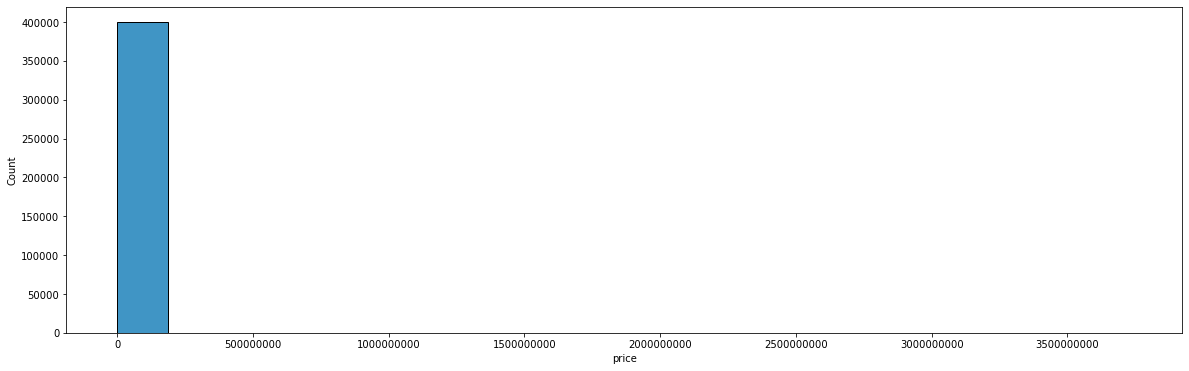

In [30]:
plt.figure(figsize=(20,6))
sns.histplot(data = df["price"], bins = 20)
plt.ticklabel_format(style='plain', axis='x')

Strangely enough we can see that something's with how our data is being represented. Why is our X axis going so far away? At first glance it seems we have some massive **OUTLIERS** that are preventing an accurate representation of the data.

At this point, and based on personal criteria, I decided to visualize an outlier as **any vehicle worth more than 50,000**. (Randomly selected)

In [31]:
# Let's find out how many outliers we have, as a percentage
df["price"][df["price"] > 50000].shape[0] / df.shape[0] * 100

2.780313241623175

Based on these results we can say that 2.78% of our data consists of outliers. In this respect, and considering my personal definition of outliers in regards to price, **I will delete all records for vehicles whose prices is above 50,000**. These prices are either typos, placeholders, or vehicles that cannot be trivially valued (classics, restorations, etc).

In [32]:
df = df[df["price"] < 50000]

I'll also do an additional sanity check and see how many vehicles are worth less than 1000 USD. I'll consider vehicles below 1k outliers if they are less than 5% of the remaining info.

In [33]:
df[df["price"] < 1000].shape[0] / df.shape[0] * 100

10.514575920594615

It's a difficult decision since **10%** of ALL samples are below 1,000 USD.

After thoughtful consideration I decided to eliminate these samples because:
* Vehicles worth / being sold at less than 1,000 USD are mostly broken cars or vehicles with major faults
* There's a high possibility these are typos here (put 900 instead of 9,000) but this cannot be corrected if true.

Among other things. 

As such, I will **delete ALL VEHICLES WITH A LISTED SALES PRICE OF LESS THAN 1,000 USD**

In [34]:
df = df[df["price"] > 1000]

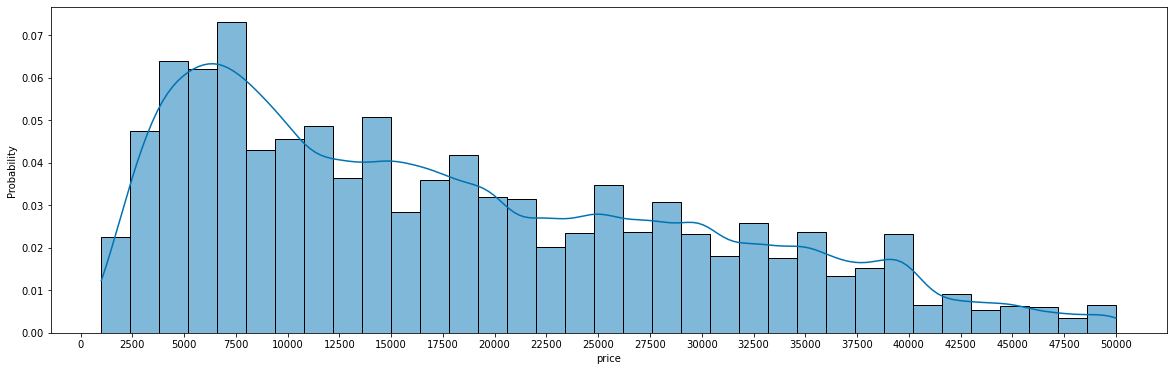

In [35]:
# Let's try visualizing the price distribution now that are rid of outliers 
plt.figure(figsize=(20,6))
ax = sns.histplot(data = df["price"], bins = 35, kde = True, stat = "probability")
# adding ticks every 5,000 USD
ax.xaxis.set_major_locator(MultipleLocator(2500)) 

As it happens with most price related distributions, we can see that the majority of sales / prices are on the left side, cheaper side. In particular, ~42% of sales are below 10,000 USD. A  mental sanity check says this is reasonable as these are used vehicles.

Another interesting insight is that, despite the right-skew of the distribution, the descent or in other words, how far the data goes to the other side, is not very steep. I interpret this as good because it seems we have a captured and understood the underlying behaviour of the data.

Now, my next step would to dive deeper into some of the features and see what else we can find and learn!

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346855 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        346855 non-null  object 
 1   price         346855 non-null  int64  
 2   year          346855 non-null  float64
 3   manufacturer  346855 non-null  object 
 4   model         346855 non-null  object 
 5   condition     346855 non-null  object 
 6   cylinders     346855 non-null  object 
 7   fuel          346855 non-null  object 
 8   odometer      346855 non-null  float64
 9   title_status  346855 non-null  object 
 10  transmission  346855 non-null  object 
 11  drive         346855 non-null  object 
 12  type          346855 non-null  object 
 13  paint_color   346855 non-null  object 
 14  state         346855 non-null  object 
 15  posting_date  346855 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 45.0+ MB


Although most of our data is in text strings, let's try running a correlation analysis to see any / importance of the few numerical features we have

<AxesSubplot:>

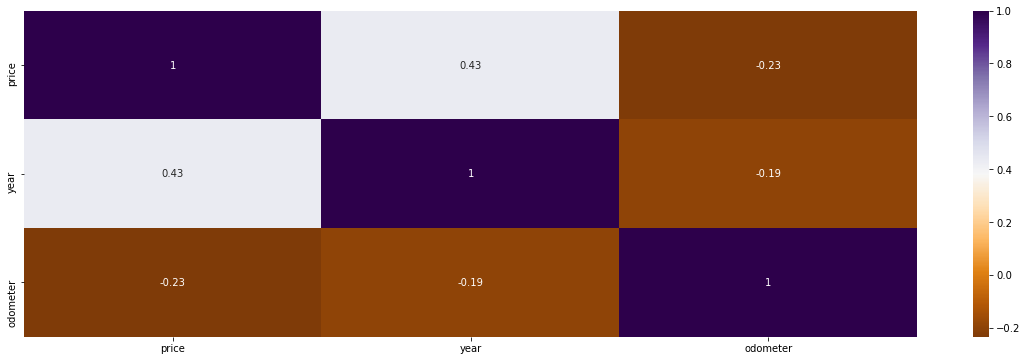

In [37]:
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(), annot = True, cmap="PuOr")

These preliminary observations are interesting and the results for odometer align with one would expect! That is, the more a car has been on the road, the less it is worth.

Nevertheless, there is a problem with year here. Year's correlation is OK, but the direction is counter to logic. The problem might stem that, since these records do not belong a specific year, the car's manufacturing year isn't the most accurate metric for the cars age. In this case we need to calculate a proxy for the vehicles age.

In [38]:
# first, we'll convert the posting date to an actual timestamp
df["posting_date"] = pd.to_datetime(df["posting_date"], utc = True)
df["posting_date"]

27       2021-05-04 17:31:18+00:00
28       2021-05-04 17:31:08+00:00
29       2021-05-04 17:31:25+00:00
30       2021-05-04 15:41:31+00:00
31       2021-05-03 19:02:03+00:00
                    ...           
426875   2021-04-04 09:21:31+00:00
426876   2021-04-04 09:21:29+00:00
426877   2021-04-04 09:21:17+00:00
426878   2021-04-04 09:21:11+00:00
426879   2021-04-04 09:21:07+00:00
Name: posting_date, Length: 346855, dtype: datetime64[ns, UTC]

In [39]:
# In this case what we really care is neither the cars year of manufacture NOR the posting date (this would always be *now* for a new prediction)
# The real variable is the cars AGE which would be -> Current_year - cars_mfg_year
df["age"] = df["posting_date"].dt.year - df["year"] # Extract the year from posting date and substract the cars MFG age to get its "age" at sale time
df["age"].value_counts()

3.0      28812
4.0      28698
8.0      25986
6.0      25240
7.0      24860
         ...  
78.0         1
121.0        1
116.0        1
99.0         1
106.0        1
Name: age, Length: 107, dtype: int64

<AxesSubplot:>

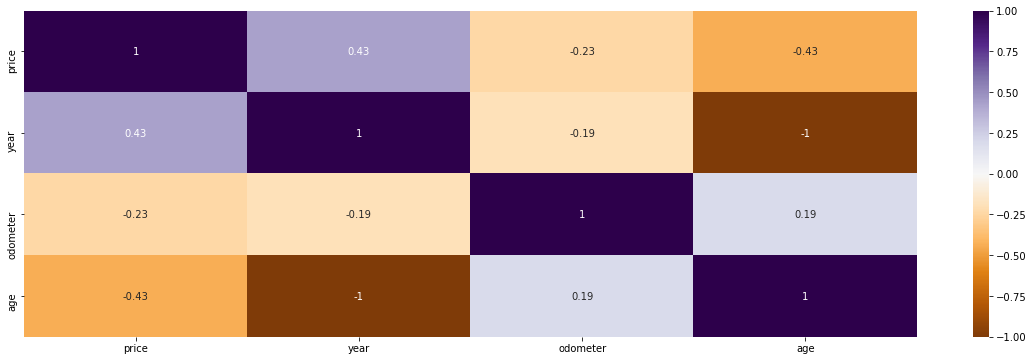

In [40]:
# Let's run correlations again to see if there's any difference
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(), annot = True, cmap="PuOr")

As desired, the feature "age" captures the correct direction of the relationship as one would expect.

In this situation, as the designer of this exercise, I have chosen to preserve **age** as the real predicting variable to maintain as it:
* contains both MFG Year and year of inquire as part of a single variable
* reduces the complexity (even if only by 1 feature) of the model

As such, I will delete both "year" and "posting date"

In [41]:
df = df.drop(columns = ["year", "posting_date"])

Now that we have created the correct proxy variable, let's try visualizing how price behaves in regards to our numerical variables!

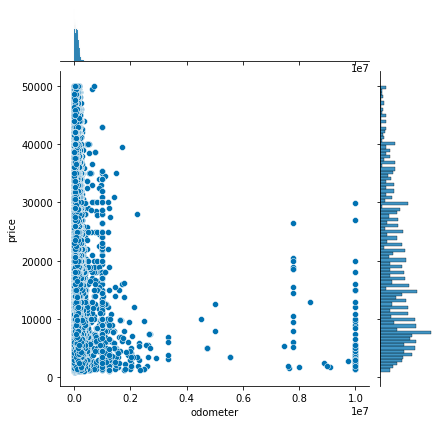

In [42]:
sns.jointplot(data = df, x = "odometer", y = "price", height = 6);

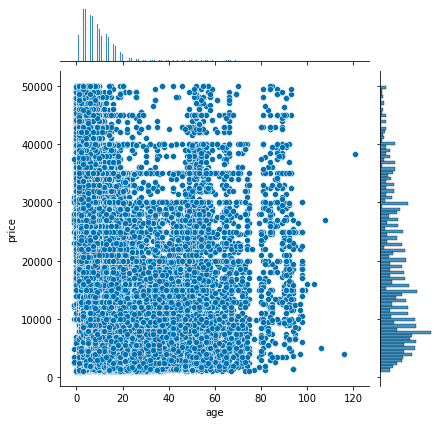

In [43]:
sns.jointplot(data = df, x = "age", y = "price", height = 6);

The relationships are difficult to visualize with the jointplots, but with some effort we can observe hints at the relationships captured by the correlations.

After analyzing the numerical features, I will now start exploring the categorical data!

In this case there's no correlations, but I will start by visualizing distributions based on countplots.

In [44]:
# separating column names for easier plotting
cat_cols = list(df.select_dtypes(include="object").columns)
num_cols = list(df.select_dtypes(include="float64"))

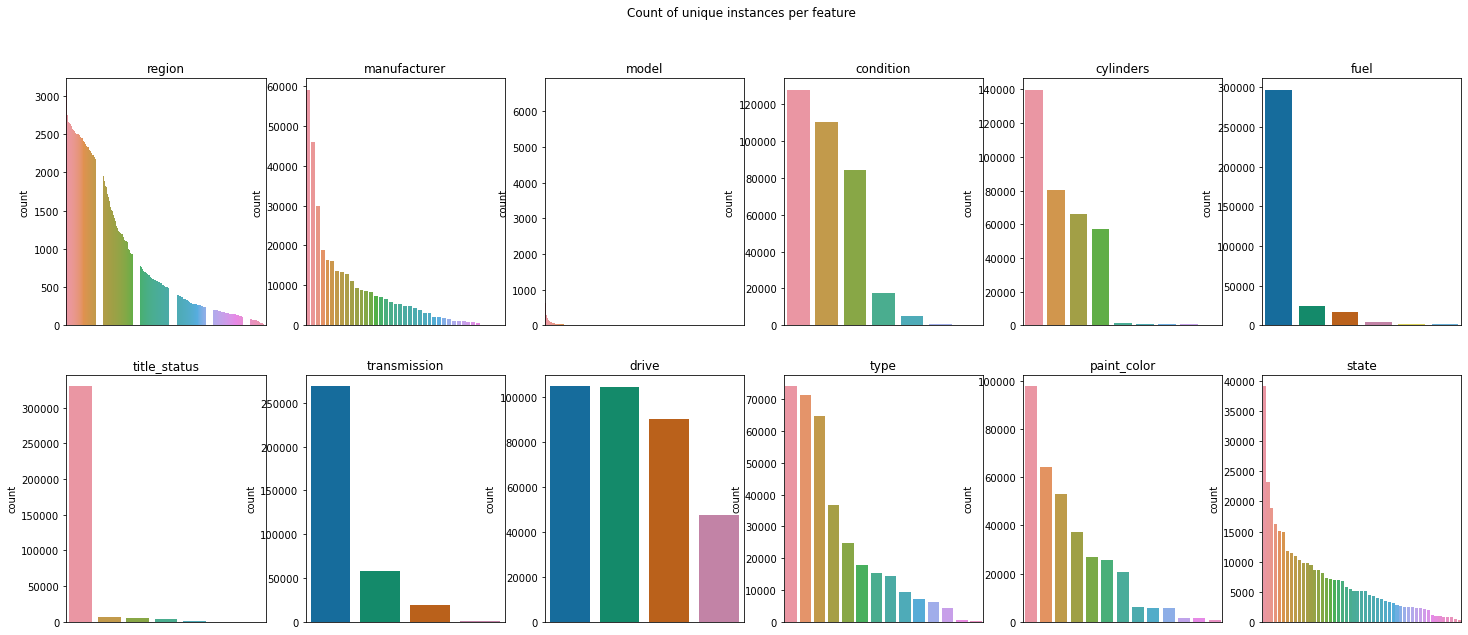

In [45]:
# This will be used only to plot the categorical columns so 6 x 2
fig, ax = plt.subplots(2,6, figsize=(25,10))

# separating rows for easier processing
row_1 = ax[0]
row_2 = ax[1]

# creating plots for the first row
for index, column in enumerate(cat_cols[:6]):
    # creating ax figure in order of value
    sns.countplot(ax=row_1[index], data = df, x=column, order = df[column].value_counts().index)
    # setting plot title
    row_1[index].set_title(column)
    # hiding xaxis since they become unreadable
    row_1[index].get_xaxis().set_visible(False)

# creating plots for the second row
for index, column in enumerate(cat_cols[6:]):
    # creating ax figure in order of value
    sns.countplot(ax=row_2[index], data = df, x=column, order = df[column].value_counts().index)
    # setting plot title
    row_2[index].set_title(column)
    # hiding xaxis since they become unreadable
    row_2[index].get_xaxis().set_visible(False)
    
fig.suptitle("Count of unique instances per feature");

At first glance there are some interesting findings:
* **TITLE_STATUS, FUEL & TRANSMISSION**: are HIGHLY unbalanced features. Although there is a large number of samples from which to draw conclusions, these imbalances make me think these variables will have negligible predicting power.
* **MODEL**: This feature does not display large counts. Let's do a deep dive and see what we find.
* **REGION & STATE**: Hold very similar (if not the same) information, yet they have different distributions. Let's see if we can choose to keep only one of them, but for now we'll hold it.

In [46]:
df["model"].nunique()

20825

In [47]:
df["model"].value_counts()

f-150                         6599
silverado 1500                4167
1500                          3510
camry                         2655
silverado                     2569
                              ... 
f-250 super duty king ranc       1
corolla..le                      1
q50 3.0t signature edition       1
commander limited awd            1
journey fwdsxt                   1
Name: model, Length: 20825, dtype: int64

It seems we have an important problem with model.

There are too many unique models! And it's not a topic of unique vehicle models, but, the model description is far too heterogenous. Let's see what we can do about it!

**A POSTERIORI CORRECTION** 
In this case I will be looking at how many models have less than 30 samples

In [48]:
df["model"].value_counts()[df["model"].value_counts() < 30]

cargo van                     29
elantra se sedan 4d           29
impreza wrx sti               29
5 series 535i gran turismo    29
promaster                     29
                              ..
f-250 super duty king ranc     1
corolla..le                    1
q50 3.0t signature edition     1
commander limited awd          1
journey fwdsxt                 1
Name: model, Length: 19168, dtype: int64

Wow, there are over 19,000 unique instances of models with less than 21 appearances. This kind of information will definitely pollute our models' learning

Let's remove all these features from the base.

In [49]:
# To be sure, let's find out exactly how many records we are going to delete
df["model"].value_counts()[df["model"].value_counts() < 30].sum()

72347

In [50]:
# extracting the string representation of all the models which less than 30 appearances
bad_models = list(df["model"].value_counts()[df["model"].value_counts() < 30].index)

# converting into an array for faster processing
bad_models = np.array(bad_models)

# creating a boolean mask. Before further processing we'll verify if this number matches what we expect
mask = df["model"].isin(bad_models)
mask.sum()

72347

In [51]:
# Let's also precalculate how many rows we'll have at the hend
df.shape[0] - mask.sum()

274508

In [52]:
# Now that i'm sure the mask is ok, I'll reserve it.
mask = ~mask

# Finally, let's do the filtering out the polluting models from the data
df = df[mask]

# verifying correct shape
df.shape[0]

274508

In [53]:
df["model"].nunique()

1657

Now it's time to do the same but for manufacturers, let's see how many (if any) have less than 150 samples

In [54]:
df["manufacturer"].value_counts()

ford               48499
chevrolet          38535
toyota             24485
honda              15749
jeep               13876
nissan             13058
ram                10871
gmc                10434
bmw                 8965
dodge               8780
hyundai             7223
subaru              6688
volkswagen          6070
mercedes-benz       5816
lexus               5712
kia                 5669
audi                4750
acura               4594
cadillac            4502
chrysler            4270
buick               3764
mazda               3345
infiniti            3106
lincoln             3009
mitsubishi          2093
volvo               1748
mini                1589
pontiac             1471
rover               1073
jaguar              1011
alfa-romeo           709
saturn               680
mercury              672
tesla                575
porsche              561
fiat                 497
harley-davidson       50
land rover             5
datsun                 4
Name: manufacturer, dtype

Fortunately it seems only 3 manufacturers match our criteria for elimination!

As such, I will exclude these manufacturers from the predictions models.

In [55]:
# let's extract only those with less than 150 samples
bad_mfg = list(df["manufacturer"].value_counts()[df["manufacturer"].value_counts() < 150].index)
#once again, convert to array
bad_mfg = np.array(bad_mfg)

# Let's create the mask
mask_mfg = df["manufacturer"].isin(bad_mfg)

# Let's invert it
mask_mfg = ~mask_mfg

# finally let's pass it

df = df[mask_mfg]

# Let's see our final shape
df.shape

(274449, 15)

In [56]:
# Finding unique models per manufacturer
df.groupby("manufacturer")["model"].nunique().sort_values(ascending = False)

manufacturer
ford             247
chevrolet        202
toyota           115
bmw               92
nissan            76
mercedes-benz     73
gmc               72
dodge             72
honda             71
ram               66
jeep              61
lexus             57
volkswagen        55
audi              51
hyundai           43
subaru            40
kia               39
infiniti          35
acura             34
cadillac          32
buick             31
chrysler          29
lincoln           26
mazda             25
volvo             21
mitsubishi        21
mini              19
jaguar            17
pontiac           16
rover             14
mercury           11
saturn            10
porsche            9
fiat               8
alfa-romeo         7
tesla              6
Name: model, dtype: int64

I have greatly reduced the complexity of the information contained in model! Hopefully this is enough to move forward!

After our findings and explorations

Fortunately, Scikit-learn provides some convenient tools for this:
* f_regression -> which is basically a one-way Anova.
* mutual_info_regression -> Analogue to its class counterpart, but for continuous variables

but first, from this point onwards, I will create the Train, Validation and Test splits! This is necessary as we **want to avoid inferences that we are not sure would apply to a ML / DL model that has not seen new data**. As such, the relevant statistics will be obtained using training sets only!

In [57]:
# Separating target and features
y = df["price"]
X_parent = df.drop(columns = "price")

In [58]:
# creating first split. The result here is the untouched test splits. The "splits" are a preliminary split that will be separated again for train and validation
X_split, X_test, y_split, y_test = train_test_split(X_parent, y, train_size = 0.8, random_state = 20) # adding random state for reproducibility

In [59]:
# creating the 2nd split. This one creates the train and validation splits
X_train, X_val, y_train, y_val = train_test_split(X_split, y_split, train_size = 0.75, random_state = 20) # adding random state for reproducibility

In [60]:
# first we need to encode the categorical and features since we can't process them as it is
## instantiating scalers
ord_enc = OrdinalEncoder()
norm_sca = StandardScaler()

## separating categorical and numerical features
cat_feats = X_train.select_dtypes(include="object")
num_feats = X_train.select_dtypes(include="float64")

## fitting scalers
ord_enc.fit(cat_feats)
norm_sca.fit(num_feats)

## re-assigning variables
cat_feats = ord_enc.transform(cat_feats)
num_feats = norm_sca.transform(num_feats)

## concatenating arrays
X_stats = np.concatenate([cat_feats, num_feats], axis=1)

In [61]:
f_arrray = f_regression(X_stats, y_train)

In [62]:
mut_info = mutual_info_regression(X_stats, y_train)

In [63]:
# creating a results table
cat_cols = list(X_train.select_dtypes(include="object").columns) # extreacting categorical columns
num_cols = list(X_train.select_dtypes(include="float64")) # extracting numerical columns
cols = cat_cols + num_cols # setting columns in correct order and then merging lists
pd.DataFrame([f_arrray[1], mut_info], index = ["f_regression", "mutual_regre"], columns = cols) #I'm only keeping the p-values of f_regression

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state,odometer,age
f_regression,1.550722e-21,1.895116e-116,5.280705e-139,0.00000,0.000000,9.884584e-61,0.000000,0.000000,0.000000,0.000000,6.293069e-119,4.093171e-11,0.000000,0.000000
mutual_regre,3.880221e-01,3.761803e-01,1.531388e+00,0.35764,0.173992,1.323056e-01,0.035753,0.324893,0.169369,0.338564,1.662242e-01,3.075173e-01,2.113924,0.602543


Before explaining the results found from this analysis I will provide some contextual information:
* f_regression from sklearn is an univariate test that mimics an ANOVA F-TEST but for a continuous problem (like price). More importantly, and as outlined in the functions page itself **IT SHOULDNT BE USED AS A STAND ALONE SELECTION METHOD**. In essence, this trains to calculate how much of the variance of target (price) is explained by the variance of a feature. The value presented in the results table is the p-value associated to the test.
* mutual information for regression is a nonparametrics (does not assume any distribution for the data) test that attempts to find the features that contribute to most to a change in the target feature (price)
* Interestingly, while many of the features had large amounts of missing values which were replaced with placeholder strings, they reflect different behaviours, providing some confidence that the transformation's did not distort the results too much.

That said, the results of both tests provide some interesting, but inconclusive insights:
1. Both methods lack consistency in determining which features might be relevant / contribute more to the variation in price, HOWEVER they do have some agreement into **which features DO NOT contribute much to the variation of the price**. In this sense, the results can be used in reverse to remove features that add little prediction power.
2. Based on the previous point the following features could be considered of LOW relevance:
    1. **TITLE_STATUS**: Has a high p-value and low mutual_information score; by both metrics this feature does not contribute much to price. Unfortunately I'm unfamiliar with these intricancies of this feature and what it represents. **On principle, this feature will be deleted from all splits** 
    2. **Region / State**: Has a high p-value and low mutual_information score. by both metrics this feature does not contribute much to price. Interestingly both features capture very similar (if not the same information), as such, one can consider it to be slightly redundant. **On principle, one of these features will be deleted from all splits.
   
After these analysis, we have some strong signals about which features to get rid of. These inputs can be combined with the observed in the EDA to finally get rid of some features!

In [64]:
# deleting unnecessary vars and cleaning namespace
del ord_enc 
del norm_sca
del cat_feats
del num_feats
del X_stats
del cat_cols
del num_cols
del cols
del X_parent
del X_train
del X_val
del X_test
del y
del y_val
del y_train
del y_test

All that said, the following features will not be considered any further for the purposes of this analysis:
* Region
* Title Status

In [65]:
df = df.drop(columns = ["region", "title_status"])

At this point I consider the EDA and feature selection process finished and I can start training models!

# Model_training

A few considerations will be explained before entering the training, fitting and evaluating models phase.

Although I'm not aiming for a specific model or solution, one the sub-goals of this project is to build a Neural Network with Keras to create the prediction model. Nevertheless, training a Neural Network is computationally expensive, thus I chose the following approach:

* I would first training sklearn Linear models (with default parameters) and use them to:
    * Find out baseline performance
    * Estimate feature weights and possible run a 2nd trial of feature selection
* Then I would run ensemble models (with default parameters) to:
    * Obtain a secondary baseline performance based on averaged results
    * Obtain feature weights (often included in the attributes of tree-based models
* Later, after performing some final adjustments, I would create the neural network.
* Finally, I would compare the results of all models and choose what works best and fine-tune hyperparameters if necessary.

In [66]:
## Separating target and features
y = df["price"]
X_parent = df.drop(columns = "price")

## creating TRUE SPLITS. The result here is the untouched test splits. The "splits" are a preliminary split that will be separated again for train and validation
X_split, X_test, y_split, y_test = train_test_split(X_parent, y, train_size = 0.8, random_state = 40) # adding random state for reproducibility

## creating the 2nd split. This one creates the train and validation splits
X_train, X_val, y_train, y_val = train_test_split(X_split, y_split, train_size = 0.75, random_state = 40) # adding random state for reproducibility

In [67]:
# encoding training arrays 
X_train, cat_encoder, num_encoder = gen_array(X_train)

In [68]:
# encoding valdition array with pre-trained encoders
X_val, cat_encoder, num_encoder = gen_array(X_val, cat_enc = cat_encoder, num_enc = num_encoder)

In [69]:
# recreating standarized indexes to be able to explore faulty values
y_val2 = y_val.reset_index().drop(columns = "index").squeeze()
y_test2 = y_test.reset_index().drop(columns = "index").squeeze()

In [70]:
# creating a list of column names in the order of concatenation for easier analysis
cat_cols = list(X_parent.select_dtypes(include = "object").columns)
num_cols = list(X_parent.select_dtypes(exclude = "object").columns)
cols = cat_cols + num_cols

## Linear_models

These are the steps I will follow with the linear models:
* Instantiate every model in a corresponding variable
* Fit all models, one by one
* Use the fitted models to generate predictions
* Calculate and store residuals for visualization purposes
* Calculate the following errors for each model:
    * Mean Absolute Error (MAE)
    * Mean Squared Error (MSE)
    * Root Mean Squared Error (RMSE)

In [71]:
lasso = LassoCV(verbose = 1, n_jobs = -1)
linear = LinearRegression(n_jobs = -1)

In [72]:
lasso.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


LassoCV(n_jobs=-1, verbose=1)

In [73]:
linear.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [74]:
# obtaining predictions
lasso_pred = lasso.predict(X_val)
linear_pred = linear.predict(X_val)

In [75]:
# calculating residuals
lasso_res = lasso_pred - y_val2
linear_res = linear_pred - y_val2

In [76]:
# creating a summary table to visualize results
MAE = [mean_absolute_error(y_val, lasso_pred), mean_absolute_error(y_val, linear_pred)]
MSE = [mean_squared_error(y_val, lasso_pred), mean_squared_error(y_val, linear_pred)]
RMSE = [np.sqrt(mean_squared_error(y_val, lasso_pred)), np.sqrt(mean_squared_error(y_val, linear_pred))]

pd.DataFrame({"MAE": MAE, "MSE": MSE, "RMSE": RMSE}, index = ["Lasso", "Linear"])

,MAE,MSE,RMSE
Lasso,5274.361308,5.258470e+07,7251.530725
Linear,3839.395956,3.413143e+07,5842.211326


Interestingly it seems a simple linear model with no regularization is better at finding relationships within the data! 
Let's try plotting the residuals to see how this looks!

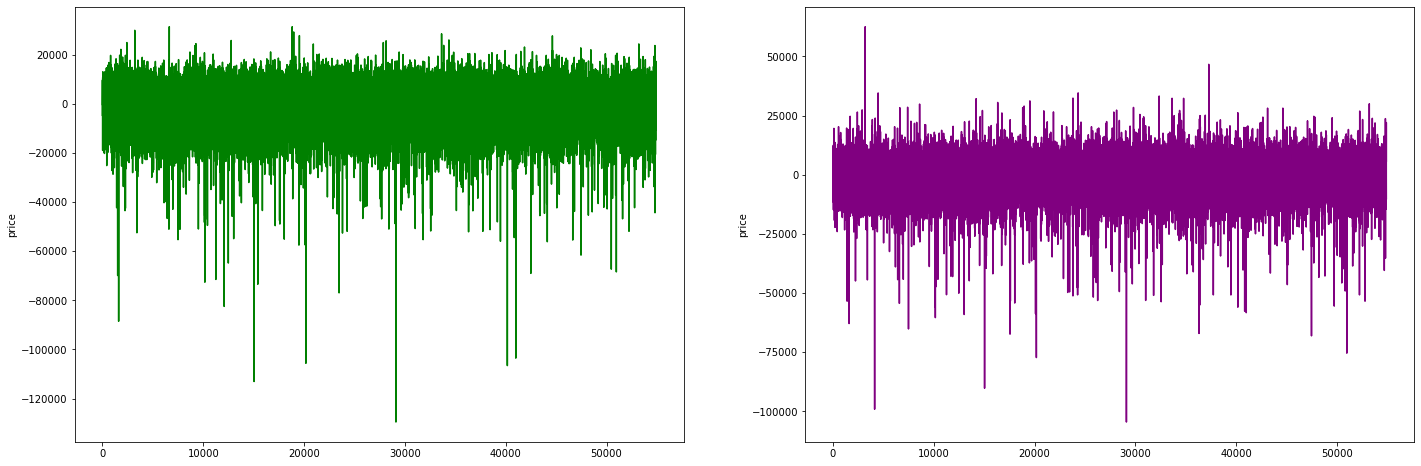

In [77]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
sns.lineplot(ax = ax[0], data = lasso_res, color = "green")
sns.lineplot(ax = ax[1], data = linear_res, color = "purple");

Observing our results, and more importantly the residuals we can observe there are some MASSIVE outliers. This tells me two things:

* The model's are currently unstable, but it seems to be related to some very specific values that may be fixable or that can be omitted from the training sets..
* Unstability aside, linear models seem to describe the data decently well. Strangely, though, the linear model with NO regularization seems to be more effective at predictions.

That said, let's explore the causes of this instability and if we can fix our process a-posteriori.

In [78]:
# Let's find the data points that are causing massive instability in our models.
## The outlier detection will be generated bi-directionally although the plots indicate the problem is that rediction understimates value.
## We only want the indeces since i'm only interested in retrieving them from the parent array
unstable_vals_idx = lasso_res[(lasso_res < -50000) | (lasso_res > 50000)].index

## retriving the actual unstable values
unstable_features = X_val[unstable_vals_idx,:]

In [79]:
unstable = inverse_trans(unstable_features, cat_enc = cat_encoder, num_enc = num_encoder)
pd.DataFrame(unstable, columns = cols)

,manufacturer,model,condition,cylinders,fuel,transmission,drive,type,paint_color,state,odometer,age
0,ford,roadster,good,8 cylinders,gas,automatic,rwd,coupe,black,hi,21220.0,89.0
1,gmc,yukon,fair,8 cylinders,gas,automatic,fwd,SUV,white,ca,9750924.0,23.0
2,chevrolet,malibu,Not relevant,Not relevant,gas,automatic,Not relevant,Not relevant,Not relevant,tx,5555555.0,29.0
3,ford,f-250,like new,4 cylinders,gas,manual,rwd,truck,black,ks,12999.0,94.0
4,buick,century,excellent,8 cylinders,gas,manual,rwd,sedan,black,co,55000.0,80.0
5,pontiac,sedan,Not relevant,Not relevant,gas,automatic,Not relevant,Not relevant,Not relevant,pa,100000.0,84.0
6,chevrolet,roadster,excellent,8 cylinders,gas,automatic,rwd,pickup,black,ca,1.0,91.0
7,ford,mustang,fair,6 cylinders,gas,automatic,rwd,Not relevant,yellow,tx,5000000.0,56.0
8,ford,roadster,excellent,8 cylinders,gas,automatic,rwd,convertible,red,in,22000.0,89.0
9,ford,roadster,Not relevant,8 cylinders,gas,automatic,rwd,Not relevant,Not relevant,or,13231.0,89.0


Unfortunately analyzing the outliers yielded no results of significance. From observing this points I can't detect any considerable trends, so I will move forward with what i have.

## Ensemble_regressors

These are the steps I will follow ensemble regressors:
* Instantiate every model in a corresponding variable
* Fit all models, one by one
* Use the fitted models to generate predictions
* Calculate and store residuals for visualization purposes
* Calculate the following errors for each model:
    * Mean Absolute Error (MAE)
    * Mean Squared Error (MSE)
    * Root Mean Squared Error (RMSE)

In [80]:
forest = RandomForestRegressor(verbose = 1, n_jobs = -1, random_state = 20) #Random state for reproducibility
boost = GradientBoostingRegressor(verbose = 1, random_state = 20) #Random state for reproducibility

In [81]:
forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished


RandomForestRegressor(n_jobs=-1, random_state=20, verbose=1)

In [82]:
boost.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1   125739852.7815           18.03m
         2   113512564.6389           17.82m
         3   103215639.5117           17.66m
         4    94452410.5891           17.45m
         5    87218829.3059           17.26m
         6    81101662.3794           17.06m
         7    75344330.3171           16.87m
         8    70593719.8439           16.68m
         9    66693509.5755           16.44m
        10    63222570.1250           16.22m
        20    44343580.5155           15.24m
        30    37834279.4788           13.21m
        40    34891914.6935           11.28m
        50    33123077.6663            9.42m
        60    31984390.2444            7.60m
        70    31105859.3285            5.75m
        80    30389975.8403            3.92m
        90    29786014.8833            1.98m
       100    29222767.7673            0.00s


GradientBoostingRegressor(random_state=20, verbose=1)

In [83]:
# obtaining predictions
forest_pred = forest.predict(X_val)
boost_pred = boost.predict(X_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [84]:
# calculating residuals
forest_res = forest_pred - y_val2.values
boost_res = boost_pred - y_val2.values

In [85]:
# creating a summary table to visualize results
MAE = [mean_absolute_error(y_val, forest_pred), mean_absolute_error(y_val, boost_pred)]
MSE = [mean_squared_error(y_val, forest_pred), mean_squared_error(y_val, boost_pred)]
RMSE = [np.sqrt(mean_squared_error(y_val, forest_pred)), np.sqrt(mean_squared_error(y_val, boost_pred))]

pd.DataFrame({"MAE": MAE, "MSE": MSE, "RMSE": RMSE}, index = ["Random_Forest", "Boosted_Trees"])

,MAE,MSE,RMSE
Random_Forest,1562.011509,9.017245e+06,3002.872813
Boosted_Trees,3918.951535,2.925794e+07,5409.061142


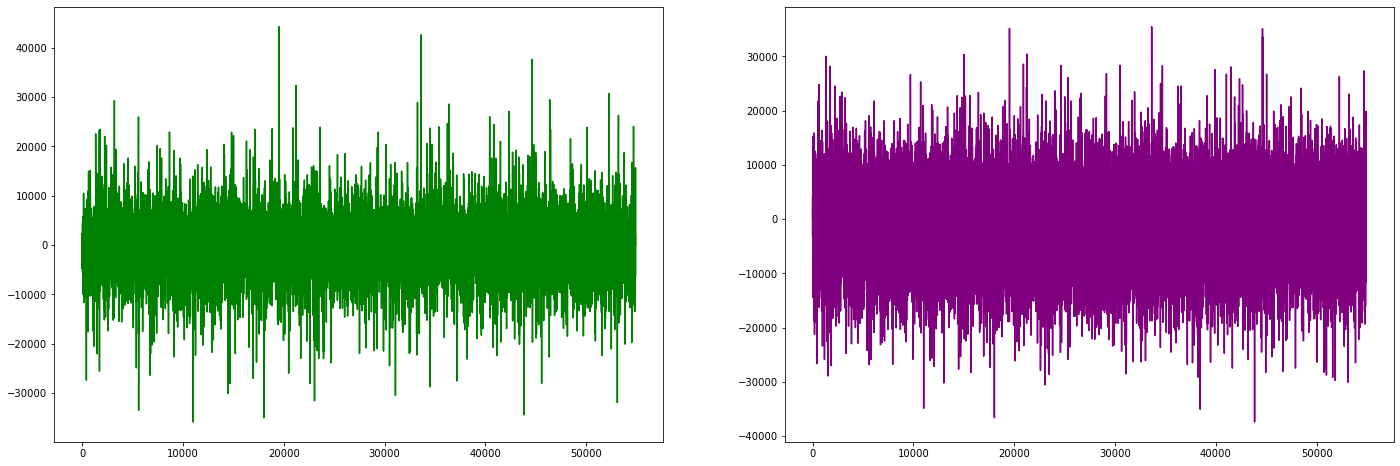

In [86]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
sns.lineplot(ax = ax[0], data = forest_res, color = "green")
sns.lineplot(ax = ax[1], data = boost_res, color = "purple");

Interestingly, the non-parametric seem to be much better at detecting trends in the underlying data. This leads me to two conclusions
* the data is NOT linearly-related, which means linear models are bad estimators.
* The exact nature of the relation is undefined, so we need something that can approximate anything...

a Neural Network!

## Keras_model

In [119]:
model = Sequential()

# Creating input layer
model.add(Input(shape = (1802,), name = "input_lay"))

# creating first layer
model.add(Dense(900, activation = "relu"))
# regularization on first one to dropout all the possibly useless attributes
model.add(Dropout(0.4))

# creating a second layer with a substantially smaller size
model.add(Dense(100, activation = "relu"))
# regularizing
model.add(Dropout(0.1))

# third layer with a substantially smaller size
model.add(Dense(11, activation = "relu"))
# no regularization in the third layer

# final layer
model.add(Dense(1))

# compiling
model.compile(optimizer = "adam", loss = "mse", metrics = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [120]:
stop = EarlyStopping(monitor = "val_loss", patience = 3, mode = "min")

In [121]:
model.fit(x = X_train, y = y_train.values, validation_data = (X_val, y_val.values), batch_size = 128, epochs = 100, callbacks = [stop])

Epoch 1/100
1287/1287 [==============================] - 20s 16ms/step - loss: 68727584.0000 - mean_absolute_error: 5289.6025 - root_mean_squared_error: 8290.2100 - val_loss: 19639276.0000 - val_mean_absolute_error: 2947.0520 - val_root_mean_squared_error: 4431.6221
Epoch 2/100
1287/1287 [==============================] - 20s 15ms/step - loss: 18088816.0000 - mean_absolute_error: 2840.9019 - root_mean_squared_error: 4253.0947 - val_loss: 15109528.0000 - val_mean_absolute_error: 2508.0359 - val_root_mean_squared_error: 3887.0977
Epoch 3/100
1287/1287 [==============================] - 20s 15ms/step - loss: 15470683.0000 - mean_absolute_error: 2594.5283 - root_mean_squared_error: 3933.2788 - val_loss: 13837034.0000 - val_mean_absolute_error: 2396.9192 - val_root_mean_squared_error: 3719.8164
Epoch 4/100
1287/1287 [==============================] - 20s 15ms/step - loss: 14489422.0000 - mean_absolute_error: 2500.2266 - root_mean_squared_error: 3806.4973 - val_loss: 12964396.0000 - val_mean

# Model_evaluation

Now that we have trained a couple of models we can go ahead test all of them versus the test set to determine which is / are the best for our task.

In [123]:
# Encoding the test set for processing.

X_test, cat_encoder, num_encoder = gen_array(X_test, cat_enc = cat_encoder, num_enc = num_encoder)

In [125]:
# creating predictions
forest_test_pred = forest.predict(X_test)
boost_test_pred = boost.predict(X_test)
lasso_test_pred = lasso.predict(X_test)
Keras_test_pred = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


In [128]:
# list of results 
MAE = [mean_absolute_error(y_test, forest_test_pred), mean_absolute_error(y_test, boost_test_pred), 
       mean_absolute_error(y_test, lasso_test_pred), mean_absolute_error(y_test, Keras_test_pred)]
MSE = [mean_squared_error(y_test, forest_test_pred), mean_squared_error(y_test, boost_test_pred), 
       mean_squared_error(y_test, lasso_test_pred), mean_squared_error(y_test, Keras_test_pred)]
RMSE = [np.sqrt(mean_squared_error(y_test, forest_test_pred)), np.sqrt(mean_squared_error(y_test, boost_test_pred)), 
       np.sqrt(mean_squared_error(y_test, lasso_test_pred)), np.sqrt(mean_squared_error(y_test, Keras_test_pred))]

In [130]:
pd.DataFrame({"MAE": MAE, "MSE": MSE, "RMSE": RMSE}, index = ["Forest", "Gradient Trees", "Lasso", "Keras"])

,MAE,MSE,RMSE
Forest,1560.997345,9.137435e+06,3022.818992
Gradient Trees,3942.934158,2.958701e+07,5439.394535
Lasso,5302.855908,5.369887e+07,7327.951454
Keras,1775.763338,8.379168e+06,2894.679202


In [159]:
# Interestingly our models produce the expected results as per the validation sets behaviour. As such, I will attempt to find the best model via residual visualization
forest_test_res = y_test.values - forest_test_pred
boost_test_res = y_test.values - boost_test_pred
lasso_test_res = y_test.values - lasso_test_pred
Keras_test_res = y_test.values - Keras_test_pred.reshape(-1,)

Text(0.5, 1.0, 'Keras Feed-Forward NN Estimator')

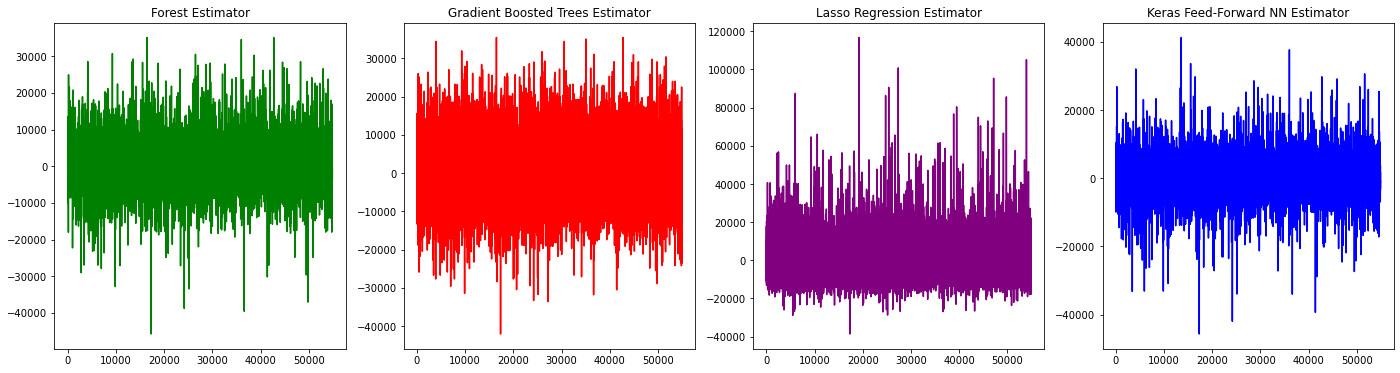

In [160]:
fig, ax = plt.subplots(1,4, figsize = (24,6))

sns.lineplot(ax = ax[0], data = forest_test_res, color = "green")
ax[0].set_title("Forest Estimator")

sns.lineplot(ax = ax[1], data = boost_test_res, color = "red")
ax[1].set_title("Gradient Boosted Trees Estimator")

sns.lineplot(ax = ax[2], data = lasso_test_res, color = "purple")
ax[2].set_title("Lasso Regression Estimator")

sns.lineplot(ax = ax[3], data = Keras_test_res, color = "blue")
ax[3].set_title("Keras Feed-Forward NN Estimator")

In [169]:
# saving keras model
save_model(model = model, filepath = "Keras Model")

INFO:tensorflow:Assets written to: Keras Model\assets


In [87]:
# saving categorical and numerical encoders
cat_encoder_file = "categorical_encoder.pkl"
num_encoder_file = "numerical_encoder.pkl"

with open(cat_encoder_file, "wb") as file:
    dump(cat_encoder, file)

with open(num_encoder_file, "wb") as file:
    dump(num_encoder, "file")

# Feature_Importance

In [107]:
features_imp = pd.DataFrame(data = forest.feature_importances_[:-2].reshape(1,-1), columns = cat_encoder.get_feature_names())

In [173]:
# For every column we will consider the feature importance to be the sum of the feature importance of all its members
manuf_imp = features_imp.iloc[:,:36].T.sum() 
model_imp = features_imp.iloc[:,36:1692].T.sum() 
condition_imp = features_imp.iloc[:,1692:1699].T.sum() 
cylinders_imp = features_imp.iloc[:,1699:1708].T.sum()
fuel_imp = features_imp.iloc[:,1708:1714].T.sum()
transmission_imp = features_imp.iloc[:,1714:1718].T.sum()
drive_imp = features_imp.iloc[:,1718:1722].T.sum()
type_imp = features_imp.iloc[:,1722:1736].T.sum()
color_imp = features_imp.iloc[:,1736:1749].T.sum()
state_imp = features_imp.iloc[:,1749:1800].T.sum()

values = {"manufacturer": manuf_imp, "model":model_imp, "condition": condition_imp, "cylinders":cylinders_imp,
         "fuel": fuel_imp, "transmission":transmission_imp, "drive":drive_imp, "type":type_imp, "color":color_imp, "state":state_imp}

In [181]:
# creating the final visualization dataframe
feature_importance = pd.DataFrame(values)
numerical_importance = pd.DataFrame(forest.feature_importances_[-2:].reshape(1,-1),columns = ["odometer", "age"])

,manufacturer,model,condition,cylinders,fuel,transmission,drive,type,color,state,odometer,age
0,0.044739,0.085959,0.011905,0.057028,0.055851,0.012075,0.102366,0.03439,0.010769,0.019112,0.127824,0.437981


In [182]:
feature_importances = pd.concat([feature_importance, numerical_importance], axis=1)
feature_importances

,manufacturer,model,condition,cylinders,fuel,transmission,drive,type,color,state,odometer,age
0,0.044739,0.085959,0.011905,0.057028,0.055851,0.012075,0.102366,0.03439,0.010769,0.019112,0.127824,0.437981


One must always be careful when analyzing feature importances as we may suffer from many mathematical and logical issues.
For example, in this case we are assuming that a feature's importance can be obtained simply by adding the relative weight of every category into its parent column, ignoring any possible collinearity (basically, redundancy) between features.

Moreover, feature importance **does not necesarilly indicate the true importance or predicting power of these variables** but simply their importance for the model.

That said, we can see that **MANUFACTURER & AGE** are, in general terms, the most important features to predict the price of a vehicle. 

# Conclusion

This project served to provide an insight into the lifecycle of a typical data scientific project and offered the possibility to apply the previously learned theory on a real-life example and on a project of personal interest.

In total, five different methods, supported through two libraries, were used for model construction. Ultimately I decided to keep the Tensorflow / Keras model as Artificial Neural Networks and DL have risen to prominency in recent times and more importantly, ANN and the universal approximation theorem allow this model to extrapolate any non-linear relationship.

The best (chosen) method was the Keras ANN with three hidden layers.

Additionally, based on the results of the found feature importances, we confirm that **building prediction models for each manufacturer would be an excellent approach for a more in-depth study**

# Limitations

* Due to limited computational power the final base used for training, validation and testing had to be reduced to an acceptable load.
* Due to the nature of the data (obtained from scraping via Craiglist) there may be hidden biases in the data, for example, over representation of certain models or brands. This can be mitigated by obtaining more data from other sources.
* Due to time constraints, a simplified one-fit-all approach had to be used for this task. A manufacturer-specific model would have been a stronger representation and much more effective at generating accurate results, as explained in the conclusions. 